In [115]:
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [116]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [117]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [118]:
numeric = train.select_dtypes(exclude='object')
categorical = train.select_dtypes(include='object')

In [119]:
num_corr = numeric.corr()
table = num_corr['SalePrice'].sort_values(ascending=False).to_frame()
cm = sns.light_palette("green", as_cmap=True)
tb = table.style.background_gradient(cmap=cm)
tb

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


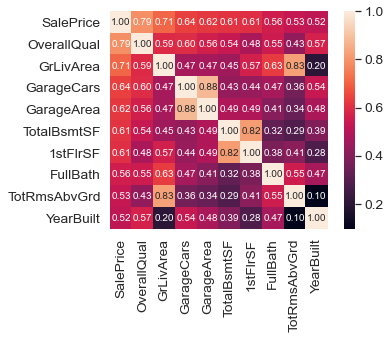

In [120]:
k = 10
cols = train.corr().nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [121]:
ntrain = train.shape[0] # число строк в train
ntest = test.shape[0]   # число строк в test
y = train['SalePrice'].to_frame()
all_data = pd.concat((train,test),sort=False).reset_index(drop = True)
all_data.drop(['SalePrice','Id'], axis = 1, inplace = True)

In [122]:
all_data = all_data.dropna(thresh = len(all_data) * 0.8, axis = 1)

all_data.shape

(2919, 74)

**Заполняем пропуски в данных**

In [123]:
# только категориальные признаки содержащие NaN
NanCat = all_data.loc[:,all_data.isna().any()].select_dtypes(include='object')

In [124]:
# заполним колонки с 1 "NaN" прямым заполнением
fill_cols = ['Electrical', 'SaleType', 'KitchenQual', 'Exterior1st',
             'Exterior2nd', 'Functional', 'Utilities', 'MSZoning']

for col in all_data[fill_cols]:
    all_data[col] = all_data[col].fillna(method='ffill')


In [125]:
#Categorical missing values
NAcols = all_data.columns
for col in NAcols:
    if all_data[col].dtype == "object":
        all_data[col] = all_data[col].fillna("None")

In [126]:
for col in NAcols:
    if all_data[col].dtype != "object":
        all_data[col]= all_data[col].fillna(0)

In [127]:
all_data.isnull().sum().sort_values(ascending=False).head()

SaleCondition    0
YearRemodAdd     0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
dtype: int64

**Преобразуем несколько признаков в более информативные признаки**

In [128]:
all_data['TotalArea'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF'] + all_data['GrLivArea'] +all_data['GarageArea']
all_data['Bathrooms'] = all_data['FullBath'] + all_data['HalfBath']*0.5 
all_data['Year average']= (all_data['YearRemodAdd']+all_data['YearBuilt'])/2

**Переводим категориальные признаки**

In [129]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)

In [130]:
# сделаем колонку Есть/Нет подвал
all_data['HasBsmt'] = pd.Series(len(all_data['TotalBsmtSF']), index=all_data.index)
all_data['HasBsmt'] = 0 
all_data.loc[all_data['TotalBsmtSF']>0,'HasBsmt'] = 1

#transform data
all_data.loc[all_data['HasBsmt']==1,'TotalBsmtSF'] = np.log(all_data['TotalBsmtSF'])

all_data = pd.get_dummies(all_data)

In [131]:
train = all_data[:ntrain]
test = all_data[ntrain:]

**Разделяем выборку**

In [132]:
from sklearn.model_selection import train_test_split
'''X = train.drop(['SalePrice'],axis='columns')'''
X = train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3)


**Стандартизируем данные**

In [133]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)
y_train = np.array(y_train)

predict_data_scaled = ss.fit_transform(test)

**Строим модель случайных лесов для отбора признаков**

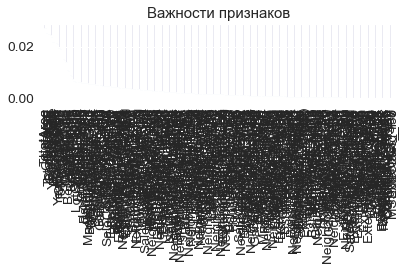

In [111]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
rfc = RandomForestClassifier()
rfc.fit(X_train_scaled, y_train)

feat_labels = train.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

plt.title('Важности признаков')
plt.bar(range(X_train_scaled.shape[1]), importances[indices], color = 'lightblue', align = 'center')
plt.xticks(range(X_train_scaled.shape[1]), feat_labels[indices], rotation = 90)
plt.xlim([-1,X_train_scaled.shape[1]])
plt.tight_layout()
plt.show()


In [134]:
from sklearn.linear_model import ElasticNet
regr = ElasticNet(alpha = 1 , l1_ratio = 0.7 , max_iter = 5)
regr.fit(X_train_scaled,y_train)
regr.score(X_test_scaled,y_test)

0.8938704433485324

In [90]:
from sklearn.model_selection import GridSearchCV
parametersGrid = {"max_iter": [1, 5, 10],
                      "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                      "l1_ratio": np.arange(0.0, 1.0, 0.1)}
grid = GridSearchCV(regr, parametersGrid, scoring='r2', cv=10)
grid.fit(X_train_scaled, y_train)

grid.best_params_

{'alpha': 1, 'l1_ratio': 0.7000000000000001, 'max_iter': 5}

In [136]:
predicts = regr.predict(predict_data_scaled)

df = pd.DataFrame()
df['Id'] = range(1461,2920)
df['SalePrice'] = predicts
df.to_csv('predictions.csv',index = False)